In [ ]:
""" New todo

1. Maybe log reduce the tightly peaked visit count predictions to avoid collapse there
2. introduce weighting for the loss functions, to stop value losing out to policy
    DO IT PRINCIPLED by looking at the gradients for the two different things.
3. add entropy regularization in training? talk to perusha
4. think about how to progress between generations in the network, how to incorporate new data, how to train on 
    old data etc. I think we want to have so many generations per x moves from the end?
    And ideally multiple network agents who have to play against one another?
    And do we change the masking for the training when using topn approaches?
5. and think of the way in which the data needs to be saved, in a structured way!
    do we weight the closer-to-terminal data?
. then progress to the below stuff.

So to be honest,
just get it running with your best guess, and see where it is going wrong! 
Maybe start off just by trying to understand what takes it a while to play a game
"""

In [ ]:
"""
okay so today we want to
1. investigate why the loss is so high when the identification of win loss and draw is looking so good
2. understand when it gives the worst attempt to predicting best moves
3. understand if there is any bug in our CEL approach?
4. start it learning from self play in actual search tree
    a. look at it playing a single game in DETAIL first. Make sure you are happy with each step 
        in the search tree before starting it running.
    b. set up continuous play continuous optimization play, where games are played and trained on 
        constantly, with the network replaced after every so many moves. 
    c. profile and see if there are any other opportunities to speed things up
    d. set up a robust and safe saving environment

"""

In [1]:
# todo
# understand the loss that we get from the validation
# see if we understand which ones it does best at following and assessing

from importlib import reload
import random
import torch
import os
import numpy as np
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import pickle

import trainer
reload(trainer)

import mcts.networks
reload(mcts.networks)

import augmentor
reload(augmentor)

from trainer import PatternTrainer
from mcts.networks import PatternsNet
from plotting import PatternPlotter
from augmentor import StateAugmentor

my_device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


In [2]:
### load a network and assess the accuracy
network_directory = os.path.join(Path.cwd(), 'saved_networks', 'v4')
npaths = os.listdir(network_directory)

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, npaths):
    _net.load_state_dict(torch.load(os.path.join(network_directory, _nloc), weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

### validation data sets for saved games:
validation_games_directory = os.path.join(Path.cwd(), 'saved_games', 'v4', 'validation')
vpath = random.choice(os.listdir(validation_games_directory))
validation_data_location = os.path.join(validation_games_directory, vpath)


In [38]:
win_tup[0].float()

AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [44]:
win_value_loss = torch.nn.MSELoss()(torch.tensor(win_tup[0]).float(), torch.ones(win_tup[0].shape))
win_value_loss.item()

0.03653384745121002

In [46]:
win_policy_loss = torch.nn.CrossEntropyLoss()(torch.tensor(win_tup[1]).float(), torch.tensor(win_tup[2]).float())
win_policy_loss

tensor(0.5801)


0.19398085776499957 0.19745135705950023 0.3511442363308623
0.5786858694261554 0.4567474472925973 0.7996833122520575
tensor(0.0376) tensor(0.0390) tensor(0.1233)
tensor(0.5787) tensor(0.4567) tensor(0.7997)


0.1394296706535161 0.16013253754554344 0.31277887529957743
0.5549854888289046 0.4477644383382744 0.8236891139876814
tensor(0.0194) tensor(0.0256) tensor(0.0978)
tensor(0.5550) tensor(0.4478) tensor(0.8290)


0.10678518090340446 0.184125315784162 0.31004108240003136
0.5467577050684629 0.4493935580846752 0.9050287159574558
tensor(0.0114) tensor(0.0339) tensor(0.0961)
tensor(0.5468) tensor(0.4494) tensor(0.9305)


0.09703449686118994 0.15167883652663133 0.34797882945443664
0.5435126501626503 0.4447096190582328 0.9695220650021767
tensor(0.0094) tensor(0.0230) tensor(0.1211)
tensor(0.5435) tensor(0.4447) tensor(0.9949)


0.10448657938801165 0.1436848395915668 0.3374982416650266
0.5402126485263539 0.4456363887485583 0.964780886128707
tensor(0.0109) tensor(0.0206) tensor(0.1139)
tensor(0

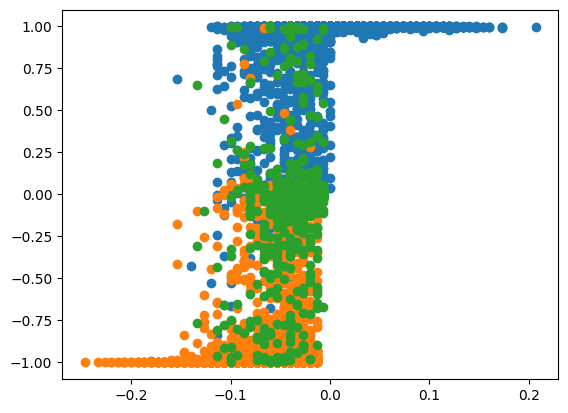

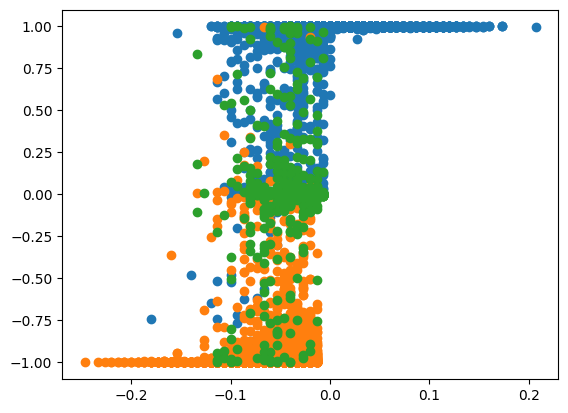

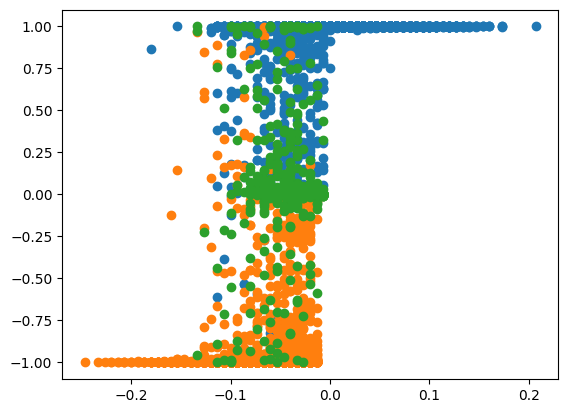

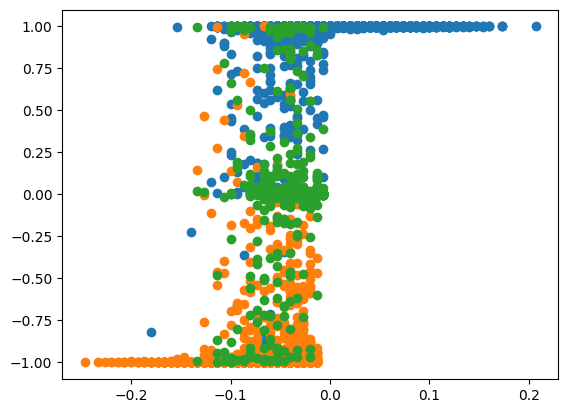

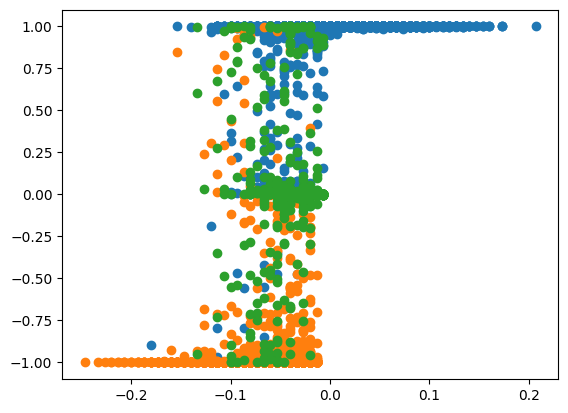

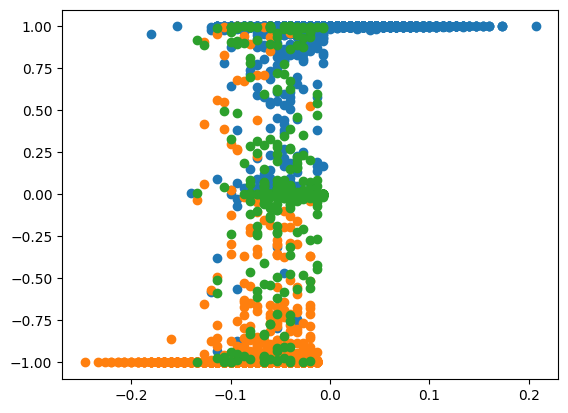

In [49]:

# assess the losses for the network in question:
for _t in ts:
    win_tup, loss_tup, draw_tup = _t.validate(data_location=validation_data_location,
                                                       num_check=10000,
                                                       is_augment=True,
                                                      )

    fig, ax = plt.subplots()
    
    ax.scatter(win_tup[-1], win_tup[0])
    ax.scatter(loss_tup[-1], loss_tup[0])
    ax.scatter(draw_tup[-1], draw_tup[0])

    win_accuracy = (((win_tup[0] - 1.0) ** 2.0).sum() / len(win_tup[0])) ** 0.5
    loss_accuracy = (((loss_tup[0] + 1.0) ** 2.0).sum() / len(loss_tup[0])) ** 0.5
    draw_accuracy = (((draw_tup[0] - 0.0) ** 2.0).sum() / len(draw_tup[0])) ** 0.5

    win_cel = _t.cross_entropy_loss(win_tup[1], win_tup[2])
    loss_cel = _t.cross_entropy_loss(loss_tup[1], loss_tup[2])
    draw_cel = _t.cross_entropy_loss(draw_tup[1], draw_tup[2])

    ### also print out the actual losses as used in the trainer:
    win_value_loss = torch.nn.MSELoss()(torch.tensor(win_tup[0]).float(), torch.ones(win_tup[0].shape))
    loss_value_loss = torch.nn.MSELoss()(torch.tensor(loss_tup[0]).float(), -torch.ones(loss_tup[0].shape))
    draw_value_loss = torch.nn.MSELoss()(torch.tensor(draw_tup[0]).float(), torch.zeros(draw_tup[0].shape))

    ### and the actual losses for policy:
    win_policy_loss = torch.nn.CrossEntropyLoss()(torch.tensor(win_tup[1]).float(), torch.tensor(win_tup[2]).float())
    loss_policy_loss = torch.nn.CrossEntropyLoss()(torch.tensor(loss_tup[1]).float(), torch.tensor(loss_tup[2]).float())
    draw_policy_loss = torch.nn.CrossEntropyLoss()(torch.tensor(draw_tup[1]).float(), torch.tensor(draw_tup[2]).float())
    
    print()
    print(win_accuracy, loss_accuracy, draw_accuracy)
    print(win_cel, loss_cel, draw_cel)
    print(win_value_loss, loss_value_loss, draw_value_loss)
    print(win_policy_loss, loss_policy_loss, draw_policy_loss)
    print()

In [ ]:

# assess the losses for the network in question:
for _t in ts:
    win_tup, loss_tup, draw_tup = _t.validate(data_location=validation_data_location,
                                               num_check=10000,
                                               is_augment=False,
)

    fig, ax = plt.subplots()
    ax.scatter(win_tup[-2], win_tup[0])
    ax.scatter(loss_tup[-2], loss_tup[0])
    ax.scatter(draw_tup[-2], draw_tup[0])

    win_accuracy = (((win_tup[0] - 1.0) ** 2.0).sum() / len(win_tup[0])) ** 0.5
    loss_accuracy = (((loss_tup[0] + 1.0) ** 2.0).sum() / len(loss_tup[0])) ** 0.5
    draw_accuracy = (((draw_tup[0] - 0.0) ** 2.0).sum() / len(draw_tup[0])) ** 0.5
    
    print(win_accuracy, loss_accuracy, draw_accuracy)

In [18]:
validation_games = ts[-1].load_data(validation_data_location)

win_tuple, loss_tuple, draw_tuple = ts[-1].validate(data_location=validation_data_location,
                                                    num_check = 10000,
                                                    is_augment = False)

In [19]:
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]

In [ ]:
#which are the worst for value for wins:
fig, ax = plt.subplots()
ax.scatter(win_tuple[-1], win_tuple[0])
ax.scatter(loss_tuple[-1], loss_tuple[0])
ax.scatter(draw_tuple[-1], draw_tuple[0])


In [20]:
win_err = np.squeeze(win_tuple[0] - 1) # Predicts 1 for small error:
loss_err = np.squeeze(loss_tuple[0] + 1) # Predicts a -1, and therefore error is small:
draw_err = np.squeeze(draw_tuple[0]) # Predicts 0 for small error:

win_sort = np.argsort(np.abs(win_err))[::-1]
loss_sort = np.argsort(np.abs(loss_err))[::-1]
draw_sort = np.argsort(np.abs(draw_err))[::-1]


In [21]:
# safe way to deal with the very small logarithm values:
def safe_log(x, eps=1e-10):
    result = np.where(x > eps, x, -10)
    np.log(result, out=result, where=result > 0)
    return result

def get_premean_cel(logits, targets):
       
    demaxed_logits = logits.T - np.max(logits, axis=1)
    exp_logits = np.exp(demaxed_logits)
    normed = exp_logits / np.sum(exp_logits, axis=0)
    
    return -np.sum(safe_log(normed) * targets.T, axis=0)
                 

In [22]:
win_cel_err = get_premean_cel(win_tuple[1], win_tuple[2])
loss_cel_err = get_premean_cel(loss_tuple[1], loss_tuple[2])
draw_cel_err = get_premean_cel(draw_tuple[1], draw_tuple[2])

win_cel_sort = np.argsort(win_cel_err)[::-1]
loss_cel_sort = np.argsort(loss_cel_err)[::-1]
draw_cel_sort = np.argsort(draw_cel_err)[::-1]


In [23]:
def get_game(games, ind, is_aug=True):
    relevant_state, relevant_vcs = games[ind][0], games[ind][1]
    auged = StateAugmentor(relevant_state, relevant_vcs)
    
    if is_aug:
        auged.full_augment()
        
    new_game = auged.create_game_from_state()
    
    return new_game


In [ ]:
### here we check for wins based on the win/ draw/ loss value estimations
### That is, we look at the WORST games in terms of the predicted result and the actual:

check_ind = 25
win_ind = win_sort[check_ind]
loss_ind = loss_sort[check_ind]
draw_ind = draw_sort[draw_ind]

check_win = get_game(wins, win_sort[check_ind])
win_plot = PatternPlotter(check_win)
win_plot.plot()
print(check_win.calculate_score(), win_tuple[0][win_sort[check_ind]])

check_loss = get_game(losses, loss_sort[check_ind])
loss_plot = PatternPlotter(check_loss)
loss_plot.plot()
print(check_loss.calculate_score(), loss_tuple[0][loss_sort[check_ind]])

check_draw = get_game(draws, draw_sort[check_ind])
draw_plot = PatternPlotter(check_draw)
draw_plot.plot()
print(check_draw.calculate_score(), draw_tuple[0][draw_sort[check_ind]])

In [24]:
def numpy_softmax(vec):
    demax = vec - np.max(vec)
    exped = np.exp(demax)
    return exped / np.sum(exped)

5806 986 360


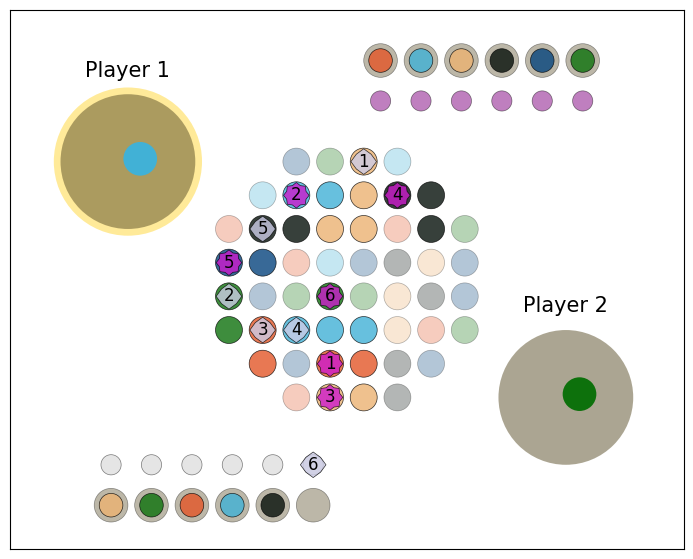

Prior prediction: (array([79], dtype=int64),)
Targets probabilities: (array([79, 80], dtype=int64),)
game score is : (40, 36)


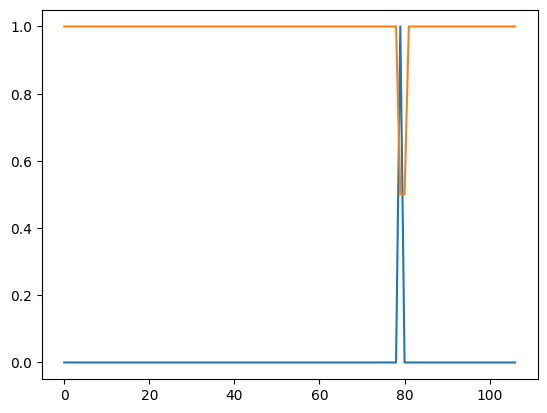

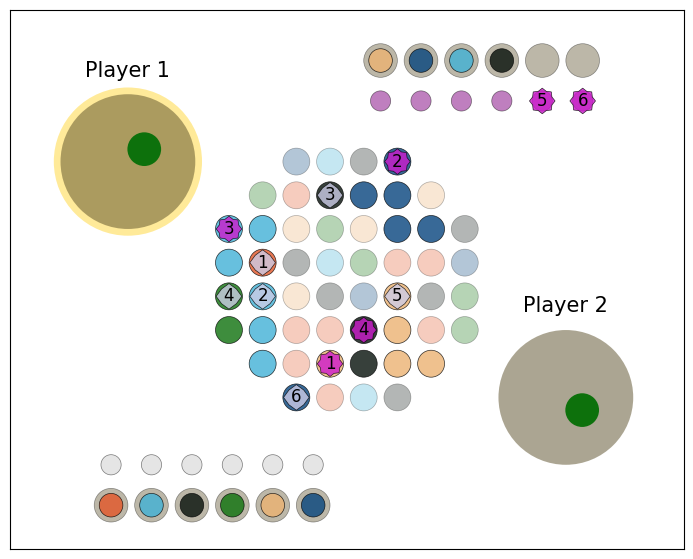

Prior prediction: (array([12, 14, 21, 23, 25, 32, 33, 40, 41], dtype=int64),)
Targets probabilities: (array([ 0,  1,  2,  4,  5,  9, 12, 13, 14, 17, 20, 21, 22, 23, 24, 25, 28,
       29, 30, 32, 33, 36, 37, 40, 41, 43, 49, 50, 51], dtype=int64),)
game score is : (28, 44)


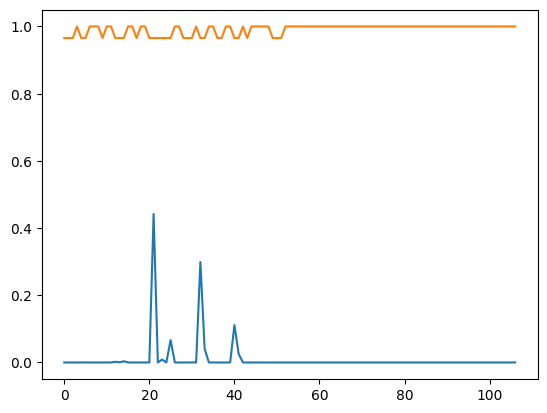

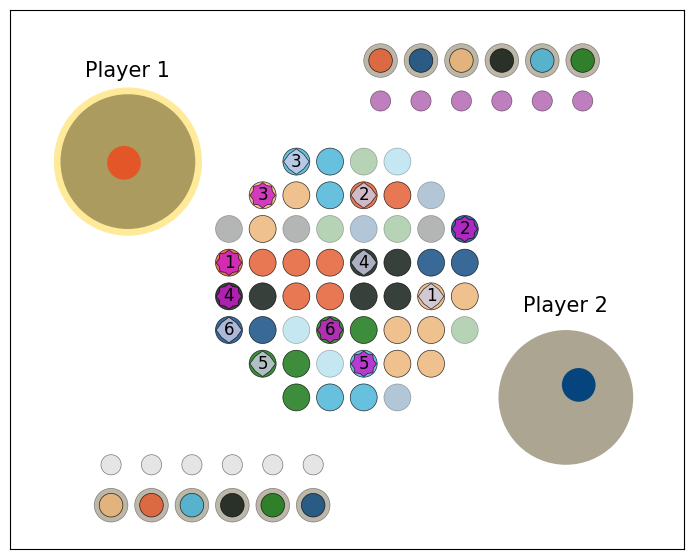

Prior prediction: (array([36], dtype=int64),)
Targets probabilities: (array([10, 12, 13, 36, 96], dtype=int64),)
game score is : (56, 62)


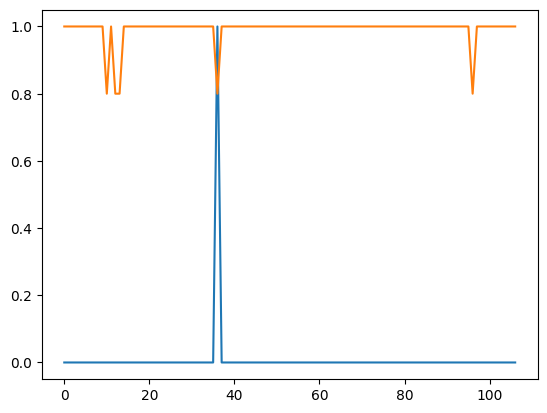

In [28]:
### Here we want to look at the worst estimations for legal/ best moves!
check_ind = 0

win_ind = win_cel_sort[check_ind]
loss_ind = loss_cel_sort[check_ind]
draw_ind = draw_cel_sort[check_ind]

print(win_ind, loss_ind, draw_ind)

###
check_win = get_game(wins, win_ind, is_aug=False)
win_plot = PatternPlotter(check_win)
win_plot.plot()

fig, ax = plt.subplots()
sm = numpy_softmax(win_tuple[1][win_ind])
print(f"Prior prediction: {np.where(sm > 1e-3) }")
print(f"Targets probabilities: {np.where(win_tuple[2][win_ind]) }")
print(f"game score is : {check_win.calculate_score()}")

ax.plot(sm)
ax.plot(1. -  win_tuple[2][win_ind])

###
check_loss = get_game(losses, loss_ind, is_aug=False)
loss_plot = PatternPlotter(check_loss)
loss_plot.plot()

fig, ax = plt.subplots()
sm = numpy_softmax(loss_tuple[1][loss_ind])
print(f"Prior prediction: {np.where(sm > 1e-3) }")
print(f"Targets probabilities: {np.where(loss_tuple[2][loss_ind]) }")
print(f"game score is : {check_loss.calculate_score()}")

ax.plot(sm)
ax.plot(1. -  loss_tuple[2][loss_ind])

###
check_draw = get_game(draws, draw_ind, is_aug=False)
draw_plot = PatternPlotter(check_draw)
draw_plot.plot()

fig, ax = plt.subplots()
sm = numpy_softmax(draw_tuple[1][draw_ind])
print(f"Prior prediction: {np.where(sm > 1e-3) }")
print(f"Targets probabilities: {np.where(draw_tuple[2][draw_ind]) }")
print(f"game score is : {check_draw.calculate_score()}")

ax.plot(sm)
ax.plot(1. -  draw_tuple[2][draw_ind])


In [ ]:
sorted(check_win.get_actions())

In [ ]:

# assess the losses for the network in question:
for _t in ts:
    _win_acc, _loss_acc, _draw_acc = _t.validate_moves(data_location=validation_data_location,
                                                       num_check=5000,
                                                       is_augment=True,
                                                       is_plot=True)
    
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:

# set network to eval mode:
my_trainer = ts[-1]
my_trainer.network.eval()

validation_games = my_trainer.load_data(validation_data_location)


# split the data set:
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]

win_vp, win_pp, win_targets, win_fc, win_sd = my_trainer.get_vc_accuracy(wins, 5000, is_augment=True)
loss_vp, loss_pp, loss_targets, loss_fc, loss_sd = my_trainer.get_vc_accuracy(losses, 5000, is_augment=True)
draw_vp, draw_pp, draw_targets, draw_fc, draw_sd = my_trainer.get_vc_accuracy(draws, 5000, is_augment=True)



In [ ]:
random.sample(range(10), 2)

In [ ]:
win_tuple[2][3138]

In [ ]:
torch.tensor(win_tuple[1].shape)

In [ ]:
def plot_targets_against_preds(priors, targets, num_samples=25):
    fig, ax = plt.subplots((num_samples + 1) // 5, 5, figsize=(8, 10))
    _axs = ax.flatten()
    _records = random.sample(range(len(priors)), num_samples)
    
    for _record, _a in zip(_records, _axs):
        pred = priors[_record]
        targ = targets[_record]
      
        _a.plot(pred)
        _a.plot(2. - targ)

    return _records

_len = 200
num_samples = 10
plot_targets_against_preds(win_tuple[1][win_sort[:_len]], 
                           win_tuple[2][win_sort[:_len]], 
                           num_samples = num_samples)



    


In [ ]:
wins[0]

In [ ]:
print(win_tuple[2][win_sort[ind]] wins[win_sort[ind]][1])

In [ ]:
ind = 143
check_win = get_game(wins, win_sort[ind], is_aug=False)
win_plot = PatternPlotter(check_win)
win_plot.plot()
print(np.where(win_tuple[3][win_sort[ind]]))
# print(check_draw.calculate_score(), draw_tuple[0][draw_sort[check_ind]])

In [ ]:
# we want to know when it does worst, in terms of value and in terms of moves
numpy_win_priors = np.array(torch.nn.functional.softmax(win_pp, dim=1))
numpy_win_priors - win_targets


In [ ]:
it = 30

pred = torch.nn.functional.softmax(win_pp, dim=1)[it]
targ = win_targets[it]

print(pred.argmax(), targ.argmax())


In [ ]:
win_vp.shape, win_pp.shape, win_targets.shape, win_fc.shape, win_sd.shape

In [ ]:
win_pp[5], win_targets[5]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(win_fc, win_vp)

In [ ]:
validation_games = _t.load_data(validation_data_location)


In [ ]:
_t.network.eval()
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]

In [ ]:
win_predictions, win_length = _t.get_MSE_accuracy(wins, num_check, is_augment=is_augment)


In [ ]:

# assess the losses for the network in question:
for _t in ts:
    _win_acc, _loss_acc, _draw_acc = _t.validate_moves(data_location=validation_data_location,
                                                       num_check=5000,
                                                       is_augment=True,
                                                       is_plot=True)
    
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:
_network_data = os.path.join(Path.cwd(), 'saved_networks', 'v3', '2025_07_09_14_39.pt')
_network = PatternsNet(in_channels=47, out_channels=128)
_network.load_state_dict(torch.load(_network_data, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
_trainer = PatternTrainer(network=_network, device=my_device)

### validation data sets for saved games:
validation_games_directory = os.path.join(Path.cwd(), 'saved_games', 'v3', 'validation')
vpaths = os.listdir(validation_games_directory)

validation_data_location = os.path.join(validation_games_directory, random.choice(vpaths))
validation_games = _trainer.load_data(validation_data_location)


In [ ]:
torch.concat(values).shape, torch.concat(priors).shape, np.concatenate(flipped_nums).shape


In [ ]:
states[0, -10:, 0, 0][-4:-2]

In [ ]:
# # # lets also see how often they choose the correct move!
num_required = 1000
batch_size = 256
game_list = validation_games[1]
is_augment = True

values = []
priors = []
flipped_nums = []

for _it in range((num_required // batch_size) + 1):
    # collect sample of games:
    sample_games = game_list[(_it * batch_size):((_it + 1) * batch_size)]

    # get the states from the games:
    _states, _vcs, _, _flipped_num, _ = zip(*sample_games)

    # stack the tensors:
    state_tensor = torch.stack(_states)
    vc_tensor = torch.tensor(np.stack(_vcs))

    # augment the states:
    states, visit_counts = _trainer.augment_sample(state_tensor, vc_tensor, is_augment=is_augment)

    # get the predicted results and the policy vectors for the states considered:
    with torch.no_grad():
        value_predictions, prior_predictions = _network(states.to(_trainer.device).float())

    # return the value and prior predictions locally:
    values.append(value_predictions.cpu())
    priors.append(prior_predictions.cpu())
    flipped_nums.append(_flipped_num)

    # # trim the wins list:
    # game_list = game_list[batch_size:]

    # if len(values) >= num_required:
    #     break

In [ ]:
bill = [1, 2, 3, 4]
bill[6:10]

In [ ]:
### load a network and assess the accuracy

# save location for the state dictionary:
npaths = [
          "2025_07_04_13_54",
         ]

# todo need some way to get the meta characteristics in a file so that can always be loaded if the 
# architecture changes:

# path locations:
nlocs = [os.path.join(Path.cwd(), 'saved_networks', network_path + '.pt') for network_path in npaths]

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, nlocs):
    _net.load_state_dict(torch.load(_nloc, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

# string and data path for the validation games:
valid_path = "VALID_2025_07_02_07_57.pkl"
dloc = os.path.join(Path.cwd(), 'saved_games', valid_path)


In [ ]:
my_trainer = ts[0]
data_location = dloc
num_check = 2000
is_augment = True
is_plot = False

validation_games = my_trainer.load_data(data_location)

# set network to eval mode:
my_trainer.network.eval()

# split the data set:
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]


In [ ]:

win_predictions, win_length = my_trainer.get_MSE_accuracy(wins, num_check, is_augment=is_augment)
loss_predictions, loss_length = my_trainer.get_MSE_accuracy(losses, num_check, is_augment=is_augment)
draw_predictions, draw_length = my_trainer.get_MSE_accuracy(draws, num_check, is_augment=is_augment)

In [ ]:
[x for x in loss_predictions[0]]

In [ ]:
def get_preds(games, num_to_take):
    # get the states from the games:
    _states, _vcs, _, _flipped_num, _ = zip(*games[:num_to_take])
    
    # stack the tensors:
    state_tensor = torch.stack(_states)
    vc_tensor = torch.tensor(np.stack(_vcs))
    
    # augment the states:
    states, _visit_counts = my_trainer.augment_sample(state_tensor, vc_tensor, is_augment=True)
    
    # get the predicted results and the policy vectors for the states considered:
    with torch.no_grad():
        # do not collect the prior policy here:
        predictions, _ = my_trainer.network(states.to(my_trainer.device).float())

    return predictions

draw_preds = get_preds(draws, 20)
win_preds = get_preds(wins, 20)
loss_preds = get_preds(losses, 20)

In [ ]:
draw_preds, win_preds, loss_preds

In [ ]:
check_visit_counts

In [ ]:
# create the game, see if you understand how it performs

_check = copy.deepcopy(wins[0])

check_tensor = _check[0]
check_visit_counts = _check[1]
check_distance_from_terminal = _check[2]
check_flipped = _check[3]
check_nod_result = _check[4]

# use augmentor to create a non-augmented game:
paug = StateAugmentor(check_tensor)
recreated_game = paug.create_game_from_state()

# fully augment, permuting the colors and rotating/ flipping:
paug.full_augment()
aug_game_1 = paug.create_game_from_state()

# and again:
paug.full_augment()    
aug_game_2 = paug.create_game_from_state()

pplotter_1 = PatternPlotter(recreated_game)
pplotter_2 = PatternPlotter(aug_game_1)
pplotter_3 = PatternPlotter(aug_game_2)

pplotter_1.plot()
pplotter_2.plot()
pplotter_3.plot()

print(aug_game_1.calculate_score(), aug_game_2.calculate_score(), recreated_game.calculate_score())
print(check_nod_result, check_tensor[-10:, 0, 0])


In [ ]:
check_tensor[:18, 5, 4], 0.0933 * 150


In [ ]:
active_order = aug_game_1.active_color_order
passive_order = aug_game_1.passive_color_order
active_color_groups = aug_game_1.active_color_groups
passive_color_groups = aug_game_1.passive_color_groups

active_score = 0
passive_score = 0

for _col, (aorder, porder) in enumerate(zip(active_order, passive_order)):
    active_score += len(active_color_groups[_col]) * aorder
    passive_score += len(passive_color_groups[_col]) * porder

print(active_score, passive_score)

In [ ]:
losing_action_arguments = [0, 1, 4]

possible_actions = [23, 15, 8, 4, 55, 12]
visit_counts = np.array([10, 20, 30, 5, 3, 1])
okay_arguments = list(set(range(len(possible_actions))) - set(losing_action_arguments))
okay_arguments

In [ ]:
filtered_visit_counts = visit_counts[okay_arguments]
filtered_visit_counts

In [ ]:
temperature= 1.0
selection_scores = filtered_visit_counts ** (1.0 / temperature)
selection_scores /= selection_scores.sum()
np.random.choice(okay_arguments, p=selection_scores).item()

In [ ]:
_argmax = np.argmax(filtered_visit_counts)
okay_arguments[_argmax]